# Análisis de sentimientos

En el presente notebook, vamos a estudiar y experimentar diferentes técnicas para realizar análisis de sentimientos a diferentes textos.

Las técnicas que veremos serán las siguientes: Modelos basados en lexicones, VADER y aprendizaje supervisado.

**Conjunto de datos**

El conjunto de datos que utilizaremos para nuestro análisis estará compuesto por un subconjunto de 10,000 reseñas de películas de un dataset de 50,000 reseñas de películas de IMDB que están clasificadas como positivas o negativas.

Dataset: https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [54]:
# Importamos algunas librerías
import pandas as pd
import numpy as np

In [55]:
# Cargamos nuestro conjunto de datos
df =  pd.read_csv("imdb_dataset.csv")
df.shape

(10000, 2)

In [56]:
df.sample(5)

,review,sentiment
444,"I've watched this movie twice, and I plan to s...",positive
1987,How do you make a totally unappealing movie ou...,negative
5622,This is hands down the worst movie I can ever ...,negative
8417,A tough life gets tougher when the three child...,positive
9609,There was nothing about this movie that I like...,negative


In [57]:
# Número de reseñas positivas y negativas
df["sentiment"].value_counts()

sentiment
positive    5068
negative    4932
Name: count, dtype: int64

## 1. Modelos no supervisados basados en lexicones

El léxico AFINN es uno de los léxicos más simples y populares que se pueden utilizar para el análisis de sentimientos. La versión actual es "AFINN-en-165" y contiene más de 3300 palabras con una puntuación de polaridad asociada a cada una de ellas.

In [58]:
# Leemos el diccionario de lexicones en un dataframe
df_lexicons = pd.read_csv("https://raw.githubusercontent.com/fnielsen/afinn/master/afinn/data/AFINN-en-165.txt", sep='\t',
                          names=["word", "polarity"])
df_lexicons.sample(10)

,word,polarity
1603,hopefully,2
1395,fucking perfect,4
1087,empathetic,2
2800,solid,2
2325,petrified,-2
1074,elated,3
3078,tricked,-2
875,dilligence,2
90,affected,-1
3171,unloved,-2


Ahora vamos a ver la distribución de polaridades de los lexicones

/home/win7/miniconda3/envs/min_web/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/win7/miniconda3/envs/min_web/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='polarity', ylabel='Count'>

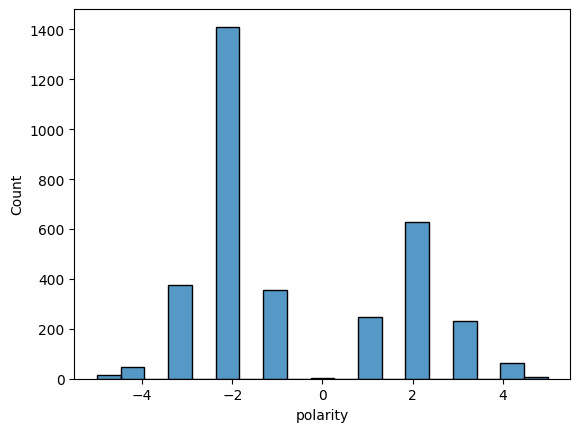

In [59]:
# Importamos seaborn para visualizar la distribución
import seaborn

seaborn.histplot(df_lexicons["polarity"])

Ahora vamos a realizar un preprocesamiento básico a nuestro conjunto de datos. Pasaremos las reseñas a minúscula. Luego, removeremos los tokens que son stopwords o contengan caracteres diferentes del alfabeto.

In [60]:
# Importamos las librerías necesarias para el preprocesamiento
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Descargamos los paquetes necesarios para el preprocesamiento
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package punkt to /home/win7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/win7/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/win7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/win7/nltk_data...


[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [61]:
# Lista de stopwords
stopwords = stopwords.words("english")
# Añadimos el tag "br" a la lista de stopwords
stopwords.append("br")
# Instanciamos el lematizador
lemmatizer = WordNetLemmatizer()

def preprocess_text(text, flag_lemmatizer=False):
    tokens = []

    for w in word_tokenize(text):
        # Convertimos a minúsculas
        w = w.lower()

        # Solo se filtran los tokens que estén compuestos por caracteres del alfabeto y que no sean stopwords
        if ((w.isalpha()) and (w not in stopwords)):
            if flag_lemmatizer:
                tokens.append(lemmatizer.lemmatize(w))
            else:
                tokens.append(w)

    return ' '.join(tokens)

In [62]:
df["review_preprocessed"] = df.review.apply(preprocess_text, flag_lemmatizer=False)
df.sample(5)

,review,sentiment,review_preprocessed
5829,... sings David Bovie in this movie. BUT IT IS...,positive,sings david bovie movie america ashamed watch ...
1275,-SPOILES- Lame south of the border adventure m...,negative,lame south border adventure movie something bl...
1100,When the first trailer for this film was viewe...,positive,first trailer film viewed curious angle storyl...
7670,This is an atrocious movie. Two demented young...,negative,atrocious movie two demented young women seduc...
4126,This is my all-time favorite Fred Astaire and ...,positive,favorite fred astaire ginger rogers film dialo...


Ahora, por cada review preprocesado obtenedremos su polaridad, el cuál será la suma de las polaridades de las palabras.

In [63]:
# Convertiremos nuestro dataframe de lexicones a un diccionario para que su acceso sea más sencillo
dic_lexicons = df_lexicons.set_index("word")["polarity"].to_dict()
list(dic_lexicons.items())[:10]

[('abandon', -2),
 ('abandoned', -2),
 ('abandons', -2),
 ('abducted', -2),
 ('abduction', -2),
 ('abductions', -2),
 ('abhor', -3),
 ('abhorred', -3),
 ('abhorrent', -3),
 ('abhors', -3)]

In [64]:
%%time
review_polarities = []

# Para cada review
for review in df["review_preprocessed"]:
  polarity = 0
  # Para cada token
  for token in word_tokenize(review):
      # Obtenemos su polaridad, si no la encuentra en el diccionario de lexicones le asigna un valor 0.
      p = dic_lexicons.get(token, 0)
      # Acumula la polaridad
      polarity += p
  review_polarities.append(polarity)

df["lexicon_polarity"] = review_polarities

CPU times: user 2.68 s, sys: 3 µs, total: 2.68 s
Wall time: 2.68 s


In [65]:
df.sample(5)

,review,sentiment,review_preprocessed,lexicon_polarity
5450,Although there are some snippets in this 4-par...,negative,although snippets documentary hinting necessit...,-15
5257,"With all the ""Adult"" innuendos in todays famil...",positive,adult innuendos todays family movies nice see ...,22
2286,So pathetic its not even funny. From the first...,negative,pathetic even funny first scene movie knew bad...,-4
2053,"I wrote spoiler alert, but there's not really ...",negative,wrote spoiler alert really much spoiled like s...,-15
3016,"Well, it's all been said about this movie and ...",negative,well said movie hate writing reviews everyone ...,-16


/home/win7/miniconda3/envs/min_web/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/win7/miniconda3/envs/min_web/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


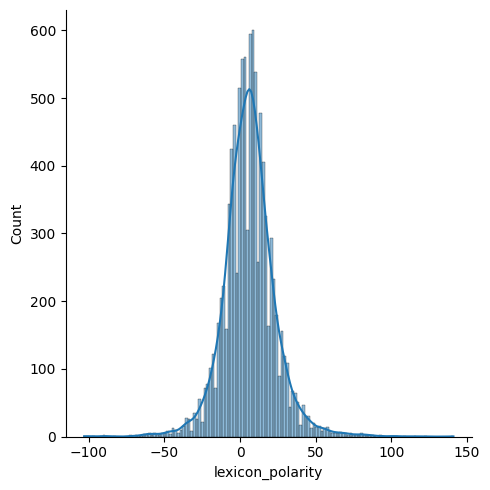

In [66]:
# Gráfico de la distribución de las polaridades
seaborn.displot(data=df["lexicon_polarity"], kde=True)

In [67]:
# Ahora, definimos que todos los review con polaridad mayor a 4 serán positivos, caso contrario negativos
df["lexicon_sentiment"] = ["positive" if p > 4 else "negative" for p in df["lexicon_polarity"]]

In [68]:
df.sample(5)

,review,sentiment,review_preprocessed,lexicon_polarity,lexicon_sentiment
4498,This little short absolutely fascinates me.<br...,positive,little short absolutely fascinates thing seen ...,16,positive
7103,This is a complex documentary that shows many ...,positive,complex documentary shows many things early ga...,21,positive
4034,The movie features another exceptional collabo...,positive,movie features another exceptional collaborati...,51,positive
2918,I just watched The Incredible Melting Man for ...,negative,watched incredible melting man second time eve...,4,negative
2271,The subsequent two seasons of this original se...,positive,subsequent two seasons original series less la...,13,positive


Y ahora obtendremos el "accuracy" entre los valores de sentimientos reales con los predichos a través del modelo basados en lexicones.

In [69]:
# Importamos algunas librerías que nos ayudará al cálculo de algunas métricas
from sklearn.metrics import accuracy_score, classification_report

# Cálculo del "accuracy"
accuracy_score(df["sentiment"], df["lexicon_sentiment"])

0.7248

In [70]:
# Más métricas
print(classification_report(df["sentiment"], df["lexicon_sentiment"]))

              precision    recall  f1-score   support

    negative       0.74      0.69      0.71      4932
    positive       0.72      0.76      0.74      5068

    accuracy                           0.72     10000
   macro avg       0.73      0.72      0.72     10000
weighted avg       0.73      0.72      0.72     10000



AFINN tiene una librería desarrollada en Python con el que podemos obtener el score de polaridad directamente

In [71]:
# Instalamos la librería
!pip install afinn

In [72]:
# Importamos la librería
from afinn import Afinn

In [73]:
# Instanciamos nuestro objeto que nos ayudará a calcular la polaridad
afn = Afinn()

In [74]:
%%time
# Obtenemos la polaridad para cada review a través de Afinn
df["afinn_polarity"] = [afn.score(review) for review in df["review_preprocessed"]]

CPU times: user 28.6 s, sys: 9.88 ms, total: 28.6 s
Wall time: 28.7 s


In [75]:
df.sample(5)

,review,sentiment,review_preprocessed,lexicon_polarity,lexicon_sentiment,afinn_polarity
9648,I thought that Baseketball was one of the most...,positive,thought baseketball one funniest films ever se...,21,positive,21.0
5399,I find myself alarmed that people are not so c...,negative,find alarmed people critical work deserves cri...,17,positive,17.0
5083,This anime seriously rocked my socks. When the...,positive,anime seriously rocked socks anime first opene...,9,positive,9.0
3045,"Hilarious, clean, light-hearted, and quote-wor...",positive,hilarious clean else ask film number one favor...,24,positive,24.0
6355,I was rather appalled to see the low rating th...,positive,rather appalled see low rating movie received ...,36,positive,36.0


In [76]:
# Ahora, aplicamos el mismo concepto que que todos los review con polaridad mayor a 4 serán positivos, caso contrario negativos
df["afinn_sentiment"] = ["positive" if p > 4 else "negative" for p in df["afinn_polarity"]]

In [77]:
# Cálculo del "accuracy" para Affin
accuracy_score(df["sentiment"], df["afinn_sentiment"])

0.7247

Podemos ver que el accuracy obtenido a través de la biblioteca Affin es el mismo que el que obtuvimos cuando realizamos el cálculo manualmente a través del diccionario de polaridades de lexicones.

## 2. VADER

Valence Aware Dictionary for sEntiment Reasoning (VADER), es un algoritmo de procesamiento de lenguaje natural que combina un enfoque de léxico de sentimientos, así como reglas gramaticales y convenciones sintácticas para expresar la polaridad y la intensidad de los sentimientos.

A diferencia de AFINN, este diccionario léxico contiene frases como "bad ass" y "the bomb", asi también emoticones como ":-)" y acrónimos cargados de sentimiento como "ROFL" y "WTF".

El diccionario de léxico de Vader contiene alrededor de 7500 "tokens" de sentimiento en total y cada uno asociada a una número de polaridad.

Además de los léxicos de sentimientos, existen estructuras que son inherentemente neutrales pero que pueden cambiar la polaridad del sentimiento (como "no" y "pero") o modificar la intensidad de la oración completa como "muy" y "extremadamente". En VADER, los desarrolladores incorporaron varias reglas heurísticas que manejan los casos de puntuación, mayúsculas, adverbios, etc.

In [78]:
# Instalamos la librería VADER
!pip install vaderSentiment

In [79]:
# Importamos la librería
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [80]:
# Instanciamos nuestro objeto analizador
analyzer = SentimentIntensityAnalyzer()

Veamos algunos ejemplos de calculo de polaridad:

In [81]:
analyzer.polarity_scores("hello")
# compound va de -1 a +1 (muy negativo a muy positivo)

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [82]:
analyzer.polarity_scores("hello :)")

{'neg': 0.0, 'neu': 0.25, 'pos': 0.75, 'compound': 0.4588}

In [83]:
analyzer.polarity_scores("hello :/")

{'neg': 0.706, 'neu': 0.294, 'pos': 0.0, 'compound': -0.34}

In [84]:
analyzer.polarity_scores("hello :(")

{'neg': 0.744, 'neu': 0.256, 'pos': 0.0, 'compound': -0.4404}

In [85]:
analyzer.polarity_scores("WTF you are doing")

{'neg': 0.602, 'neu': 0.398, 'pos': 0.0, 'compound': -0.6739}

In [86]:
analyzer.polarity_scores("WTF you are doing :@")

{'neg': 0.728, 'neu': 0.272, 'pos': 0.0, 'compound': -0.8415}

Ahora, obtenedremos los valores de polaridad utilizando la librería VADER.

In [87]:
%%time
# Obteniendo la polaridad
df["vader_polarity"] = [analyzer.polarity_scores(r)["compound"] for r in df["review"]]

CPU times: user 19.2 s, sys: 19.9 ms, total: 19.2 s
Wall time: 19.2 s


/home/win7/miniconda3/envs/min_web/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/win7/miniconda3/envs/min_web/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


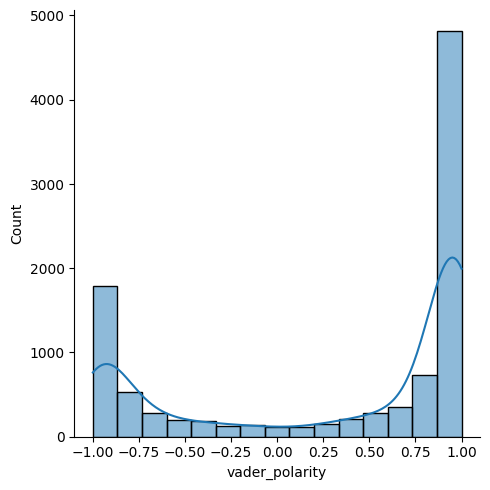

In [88]:
# Gráfico de la distribución de las polaridades
seaborn.displot(data=df["vader_polarity"], kde=True)

In [89]:
df.sample(5)

,review,sentiment,review_preprocessed,lexicon_polarity,lexicon_sentiment,afinn_polarity,afinn_sentiment,vader_polarity
6771,"Looking through the other comments, I'm amazed...",negative,looking comments amazed warnings potential vie...,-16,negative,-16.0,negative,-0.9505
9330,"I wasn't expecting much from this film, but wa...",negative,expecting much film eager try something initia...,-14,negative,-14.0,negative,-0.9678
3442,"I watched this today, partially attracted to t...",negative,watched today partially attracted cast partly ...,-7,negative,-7.0,negative,-0.8228
1695,"Valeria, an elegant and pretty young lady live...",positive,valeria elegant pretty young lady lives world ...,16,positive,16.0,positive,0.9588
6293,"I can honestly say that ""Death Bed: The Bed Th...",positive,honestly say death bed bed eats much better mo...,-12,negative,-12.0,negative,-0.4351


In [90]:
# Ahora, definimos que todos los review con polaridad mayor a 0.5 serán positivos, caso contrario negativos
df["vader_sentiment"] = ["positive" if p >= 0.5 else "negative" for p in df["vader_polarity"]]

In [91]:
df.sample(5)

,review,sentiment,review_preprocessed,lexicon_polarity,lexicon_sentiment,afinn_polarity,afinn_sentiment,vader_polarity,vader_sentiment
8038,this movie made me watch Paul W.S. Anderson's ...,negative,movie made watch paul anderson enjoy even goin...,-2,negative,-2.0,negative,-0.9435,negative
7739,Overlong drama that isn't capable of making an...,negative,overlong drama capable making real point becam...,5,positive,5.0,positive,0.6676,positive
5482,This movie had a very convoluted plot and very...,negative,movie convoluted plot contrived setting frankl...,5,positive,5.0,positive,0.7430,positive
5138,Lars von Trier's Europa is a worthy echo of Th...,positive,lars von trier europa worthy echo third man am...,-13,negative,-13.0,negative,-0.8991,negative
8917,The truth is that a film based on a Harold Rob...,negative,truth film based harold robbins novel going wi...,19,positive,19.0,positive,0.8241,positive


Y ahora obtendremos el "accuracy" entre los valores de sentimientos reales con los predichos a través del modelo VADER.

In [92]:
# Cálculo del "accuracy"
accuracy_score(df["sentiment"], df["vader_sentiment"])

0.7132

In [93]:
# Más métricas
print(classification_report(df["sentiment"], df["vader_sentiment"]))

              precision    recall  f1-score   support

    negative       0.77      0.60      0.68      4932
    positive       0.68      0.82      0.74      5068

    accuracy                           0.71     10000
   macro avg       0.72      0.71      0.71     10000
weighted avg       0.72      0.71      0.71     10000



## 3. Aprendizaje Supervisado

Finalmente, utilizaremos un modelo de aprendizaje supervisado, en este caso un clasificador "Random Forest". En esta ocasión, preprocesaremos la información con el flag de lematización prendido, esto quiere decir que se lematizará las palabras del conjunto de datos antes de enviarselas al modelo.

In [94]:
%%time
# Preprocesamos las reseñas pero en esta ocasión con el flag prendido para lemmatizar los tokens
df["review_preprocessed_lemmatize"] = np.vectorize(preprocess_text)(df["review"], flag_lemmatizer=True) # quitar esto para word embedding

CPU times: user 15.2 s, sys: 96.5 ms, total: 15.2 s
Wall time: 15.3 s


In [95]:
df[["review", "review_preprocessed", "review_preprocessed_lemmatize"]]

,review,review_preprocessed,review_preprocessed_lemmatize
0,Giant crabs cursing in Japanese? What was in t...,giant crabs cursing japanese drink terrible mo...,giant crab cursing japanese drink terrible mov...
1,The cast is admirably chosen and well-balanced...,cast admirably chosen cinematography excellent...,cast admirably chosen cinematography excellent...
2,One of the better movies to come out of the 19...,one better movies come movie tells story distu...,one better movie come movie tell story disturb...
3,Move over Manos. Back off Boogens. It doesn't ...,move manos back boogens take baby genius know ...,move manos back boogens take baby genius know ...
4,Being advertised as the most expensive movie e...,advertised expensive movie ever made czech rep...,advertised expensive movie ever made czech rep...
...,...,...,...
9995,"Superb cast, more please!<br /><br />If you ca...",superb cast please catch anything else written...,superb cast please catch anything else written...
9996,"A typical Clausen film, but then again not typ...",typical clausen film typical clausen writes di...,typical clausen film typical clausen writes di...
9997,DEATHSTALKER is perfect for B-fantasy movie fa...,deathstalker perfect movie fans barely travest...,deathstalker perfect movie fan barely travesty...
9998,If you're one of those people who doesn't real...,one people really like sometimes ideas surreal...,one people really like sometimes idea surreal ...


Ahora dividiremos el dataset en conjuntos de datos de entrenamiento y pruebas.

In [96]:
# Importamos la librería que nos ayudará a dividir los conjuntos de datos
from sklearn.model_selection import train_test_split

# Dividimos los conjuntos de datos
X_train, X_test, y_train, y_test = train_test_split(df["review_preprocessed_lemmatize"], df["sentiment"], test_size=0.05, random_state=2023)

Utilizaremos la técnica TF-IDF para la vectorización de los datos

USAR word embeddings e n lugar de 

In [97]:
# Importamos TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorizamos
# min_df: ignora a los términos que aparecen en menos de un número de documentos
tfidf = TfidfVectorizer(tokenizer=word_tokenize, use_idf=True, min_df=3, max_features=5000).fit(X_train.values.tolist() + X_test.values.tolist())

# Obtenemos los vectores
X_train_tf = tfidf.transform(X_train.values).toarray()
X_test_tf = tfidf.transform(X_test.values).toarray()

# Dimensiones de las variables independientes
X_train_tf.shape, X_test_tf.shape

/home/win7/miniconda3/envs/min_web/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


((9500, 5000), (500, 5000))

Ahora sí, entrenamos un modelo "Random Forest"

In [98]:
# Importamos la librería "Random Forest"
from sklearn.ensemble import RandomForestClassifier

# Entrenamos
random_forest = RandomForestClassifier().fit(X_train_tf, y_train)

In [99]:
# Obtenemos la predicciones de nuestro conjunto de pruebas
y_pred = random_forest.predict(X_test_tf)

In [100]:
# Calculamos el accuracy entre los valores reales de la data de prueba con los valores predichos.
accuracy_score(y_test, y_pred)
# Nota: estos valores no son "100%" comparables con los 2 modelos que realizamos más arriba ya que, por un lado hemos lematizado los conjuntos
# de datos y otro que estamos calculando el score sobre un conjunto de datos de prueba (no fue visto en entrenamiento).

0.846

Probando el modelo con otras reseñas ...

In [101]:
sentence = "The movie was great"
other_review = preprocess_text(sentence, flag_lemmatizer=True)
random_forest.predict(tfidf.transform([other_review]).toarray())

array(['positive'], dtype=object)

In [102]:
sentence = "The movie was really bad"
other_review = preprocess_text(sentence, flag_lemmatizer=True)
random_forest.predict(tfidf.transform([other_review]).toarray())

array(['negative'], dtype=object)

In [103]:
sentence = "Henry Cavill performance was really bad"
other_review = preprocess_text(sentence, flag_lemmatizer=True)
random_forest.predict(tfidf.transform([other_review]).toarray())

array(['negative'], dtype=object)

In [104]:
sentence = "Cris Evans is a good actor"
other_review = preprocess_text(sentence, flag_lemmatizer=True)
random_forest.predict(tfidf.transform([other_review]).toarray())

array(['positive'], dtype=object)

In [105]:
sentence = "How much is it?"
other_review = preprocess_text(sentence, flag_lemmatizer=True)
random_forest.predict(tfidf.transform([other_review]).toarray())

array(['positive'], dtype=object)